In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
file_path = "Sentiment_Data.csv"  # Update the path if needed

# Attempt different encodings if UTF-8 fails
encodings = ["utf-8", "ISO-8859-1", "latin1"]

for enc in encodings:
    try:
        df = pd.read_csv(file_path, encoding=enc)
        print(f"Successfully loaded with encoding: {enc}")
        break  # Stop if successful
    except UnicodeDecodeError:
        print(f"Encoding {enc} failed, trying next...")

Encoding utf-8 failed, trying next...
Successfully loaded with encoding: ISO-8859-1


In [3]:
df.head()

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [4]:
df.isnull().sum()

Tweet        1
Sentiment    0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
import re

# Function to remove URLs
def remove_urls(text):
    return re.sub(r"http\S+|www\S+", "", text)

# Function to remove mentions and hashtags
def remove_mentions_hashtags(text):
    return re.sub(r"@\w+|#\w+", "", text)

# Apply regex transformations
df["Tweet_Cleaned"] = df["Tweet"].astype(str)
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(remove_urls)
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(remove_mentions_hashtags)

# Count regex transformations
regex_count = df["Tweet"].str.contains(r"http\S+|www\S+|@\w+|#\w+", regex=True).sum()

print(f"Regex Applied: {regex_count} changes")

Regex Applied: 405578 changes


In [7]:
import emoji

# Function to replace emojis with text equivalents
def replace_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))  # Convert emoji to text

# Apply emoji transformation
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(replace_emojis)

# Count emoji replacements
emoji_count = df["Tweet"].str.contains(r"[^\w\s,]", regex=True).sum()

print(f"Emojis Replaced: {emoji_count} emojis")

Emojis Replaced: 449126 emojis


In [8]:
# Slang dictionary
slang_dict = {
    "brb": "be right back",
    "lol": "laugh out loud",
    "idk": "I don’t know",
    "imo": "in my opinion",
    "btw": "by the way"
}

# Function to expand slangs
def expand_slang(text):
    words = text.split()
    return " ".join([slang_dict[word.lower()] if word.lower() in slang_dict else word for word in words])

# Apply slang transformation
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(expand_slang)

# Count slang replacements
slang_count = sum([df["Tweet"].str.contains(word, case=False, na=False).sum() for word in slang_dict.keys()])

print(f"Slangs Expanded: {slang_count} slangs")

Slangs Expanded: 7142 slangs


In [9]:
sentiment_mapping = {
    "Mild_Pos": "Positive",
    "Strong_Pos": "Positive",
    "Mild_Neg": "Negative",
    "Strong_Neg": "Negative",
    "Neutral": "Neutral"
}

df["Sentiment"] = df["Sentiment"].map(sentiment_mapping)
print(df["Sentiment"].value_counts())

Sentiment
Positive    297704
Neutral      77015
Negative     76612
Name: count, dtype: int64


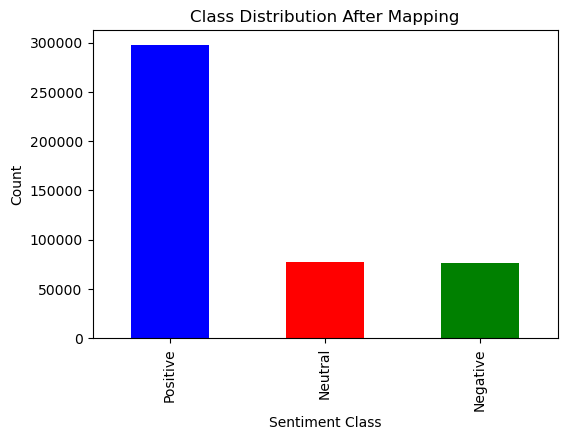

In [10]:
# Plot class distribution
plt.figure(figsize=(6,4))
df["Sentiment"].value_counts().plot(kind="bar", color=["blue", "red", "green"])
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.title("Class Distribution After Mapping")
plt.show()

In [11]:
df.head()

,Tweet,Sentiment,Tweet_Cleaned
0,@_angelica_toy Happy Anniversary!!!....The Day...,Positive,Happy Anniversary!!!....The Day the FreeDUMB D...
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Positive,Happy Anniversary!!!....The Day the FreeDUMB D...
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Positive,Happy Anniversary!!!....The Day the FreeDUMB D...
3,@NChartierET Happy Anniversary!!!....The Day t...,Positive,Happy Anniversary!!!....The Day the FreeDUMB D...
4,@tabithapeters05 Happy Anniversary!!!....The D...,Positive,Happy Anniversary!!!....The Day the FreeDUMB D...


In [12]:
# Splitting data into Train (80%) and Test (20%) before vectorizing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sentiment'])

# Extract the target labels for training and testing
y_train = train_df["Sentiment"].values  # Numeric labels for training data
y_test = test_df["Sentiment"].values   # Numeric labels for testing data

print(y_train.shape)
print(y_test.shape)

(361064,)
(90267,)


In [13]:
import nltk
from nltk.tokenize import word_tokenize

# Download tokenizer if not available
nltk.download("punkt")

# Ensure tokenization is applied to both train and test data
train_df["Tokens"] = train_df["Tweet_Cleaned"].apply(word_tokenize)
test_df["Tokens"] = test_df["Tweet_Cleaned"].apply(word_tokenize)

# Print sample tokenized tweets
train_df[["Tweet_Cleaned", "Tokens"]].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chetn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Tweet_Cleaned,Tokens
242248,"Help maybe on the way ,either this way or thro...","[Help, maybe, on, the, way, ,, either, this, w..."
223033,What Theyâre NOT Telling You About the Freed...,"[What, Theyâre, NOT, Telling, You, About, th..."
385856,You realize the only people in that area that ...,"[You, realize, the, only, people, in, that, ar..."
449888,freedom fighters attacked convoy of State agen...,"[freedom, fighters, attacked, convoy, of, Stat..."
30883,"Canadian Freedom Convoy protestors, as well as...","[Canadian, Freedom, Convoy, protestors, ,, as,..."


In [14]:
train_df.head()

,Tweet,Sentiment,Tweet_Cleaned,Tokens
242248,"@unvaxxedovaries Help maybe on the way ,either...",Positive,"Help maybe on the way ,either this way or thro...","[Help, maybe, on, the, way, ,, either, this, w..."
223033,What Theyâre NOT Telling You About the Freed...,Positive,What Theyâre NOT Telling You About the Freed...,"[What, Theyâre, NOT, Telling, You, About, th..."
385856,@kareemm786 @BotheredBoy You realize the only ...,Neutral,You realize the only people in that area that ...,"[You, realize, the, only, people, in, that, ar..."
449888,#BRA freedom fighters attacked convoy of State...,Negative,freedom fighters attacked convoy of State agen...,"[freedom, fighters, attacked, convoy, of, Stat..."
30883,@keirsco1 @tooboopedoo23 @disclosetv Canadian ...,Positive,"Canadian Freedom Convoy protestors, as well as...","[Canadian, Freedom, Convoy, protestors, ,, as,..."


In [15]:
train_df.drop("Tweet_Cleaned", axis = 1, inplace = True)

In [16]:
train_df.drop("Tweet", axis = 1, inplace = True)

In [17]:
test_df.drop("Tweet", axis = 1, inplace = True)

In [18]:
test_df.drop("Tweet_Cleaned", axis = 1, inplace = True)

In [19]:
train_df.head()

,Sentiment,Tokens
242248,Positive,"[Help, maybe, on, the, way, ,, either, this, w..."
223033,Positive,"[What, Theyâre, NOT, Telling, You, About, th..."
385856,Neutral,"[You, realize, the, only, people, in, that, ar..."
449888,Negative,"[freedom, fighters, attacked, convoy, of, Stat..."
30883,Positive,"[Canadian, Freedom, Convoy, protestors, ,, as,..."


In [20]:
test_df.head()

,Sentiment,Tokens
65551,Negative,"[Thanks, Rachel, ,, excellent, work, !, The, i..."
435531,Negative,"[Make, no, mistake, ,, this, so, called, is, a..."
364060,Neutral,"[Drama, queen, Ottawa, City, Councilor, charac..."
71837,Positive,"[If, you, 're, Thankful, for, the, Retweet, .,..."
337631,Neutral,"[Calgary, Police, Officer, reacts, to, trucker..."


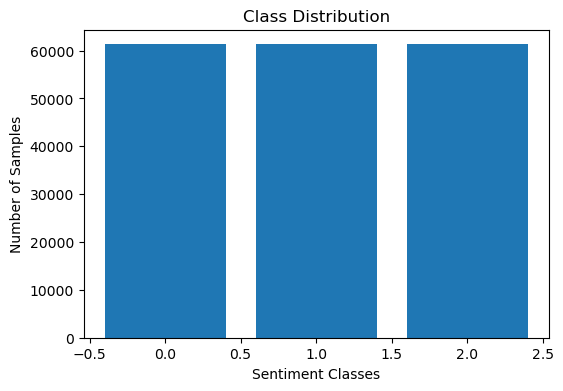

In [21]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

# Assuming you have 'y_train' (sentiments) and 'train_embeddings' (features)
undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(train_df, y_train)

# Convert Sentiments to Numeric Labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(np.unique(y_train), np.bincount(y_train))
plt.xlabel("Sentiment Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

In [22]:
from gensim.models import Word2Vec

# Train Word2Vec Model
vector_size = 100  # You can choose between 64 to 300
w2v_model = Word2Vec(
    sentences= X_train["Tokens"],  # Use tokenized tweets
    vector_size = vector_size,  
    window=5,  # Context window size
    min_count=2,  # Ignore words appearing less than twice
    sg=1  # Set sg=1 for Skip-gram, sg=0 for CBOW
)

# Save the trained model (optional)
w2v_model.save("word2vec_tweet.model")

# Print summary
print(f"Word2Vec Model Trained with {len(w2v_model.wv)} words in vocabulary.")

Word2Vec Model Trained with 59187 words in vocabulary.


In [23]:
import numpy as np

def get_embedding(tweet_tokens, model):
    embeddings = [model.wv.get_vector(word, norm=False) for word in tweet_tokens if word in model.wv]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size, dtype=np.float32)

X_train = np.array([get_embedding(tokens, w2v_model) for tokens in X_train["Tokens"]], dtype=np.float32)
X_test = np.array([get_embedding(tokens, w2v_model) for tokens in test_df["Tokens"]], dtype=np.float32)

In [31]:
y_train.shape

(183867,)

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class PositionEmbedding(layers.Layer):
    def __init__(self, sequence_length, embedding_dim):
        super().__init__()
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embedding_dim)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
        return self.position_embeddings(positions)

In [35]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization()
        self.norm2 = layers.LayerNormalization()
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)  # Residual Connection
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)  # Residual Connection

In [43]:
def build_model(seq_length, embed_dim, num_heads, ff_dim, num_classes):
    inputs = keras.Input(shape=(seq_length, embed_dim))
    
    # Positional Encoding
    pos_embedding = PositionEmbedding(seq_length, embed_dim)(inputs)
    x = inputs + pos_embedding  # Add positional embeddings

    # Transformer Blocks
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)  # Pass 'training' argument
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)  # Pass 'training' argument

    # Global Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Fully Connected Output
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)  # Multi-class classification

    return keras.Model(inputs, outputs)

In [39]:
# Reshape input to fit Transformer (batch_size, sequence_length, embedding_dim)
seq_length = 1  # Since each sample is already a 100-d vector
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Convert to categorical (one-hot encoding)
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [47]:
import time

# Enable GPU acceleration
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

with tf.device(device):
    model = build_model(seq_length=1, embed_dim=100, num_heads=4, ff_dim=128, num_classes=num_classes)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    start_time = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=5)
    end_time = time.time()
    training_time = end_time - start_time

Epoch 1/5
5746/5746 ━━━━━━━━━━━━━━━━━━━━ 204s 32ms/step - accuracy: 0.5753 - loss: 0.8995 - val_accuracy: 0.7126 - val_loss: 0.7242
Epoch 2/5
5746/5746 ━━━━━━━━━━━━━━━━━━━━ 182s 32ms/step - accuracy: 0.6354 - loss: 0.8132 - val_accuracy: 0.6838 - val_loss: 0.7963
Epoch 3/5
5746/5746 ━━━━━━━━━━━━━━━━━━━━ 177s 31ms/step - accuracy: 0.6477 - loss: 0.7907 - val_accuracy: 0.7277 - val_loss: 0.6894
Epoch 4/5
5746/5746 ━━━━━━━━━━━━━━━━━━━━ 182s 32ms/step - accuracy: 0.6535 - loss: 0.7809 - val_accuracy: 0.6590 - val_loss: 0.7633
Epoch 5/5
5746/5746 ━━━━━━━━━━━━━━━━━━━━ 174s 30ms/step - accuracy: 0.6604 - loss: 0.7669 - val_accuracy: 0.7148 - val_loss: 0.6927


In [49]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 1, 100)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ position_embedding_2          │ (1, 100)                  │             100 │ input_layer_4[0][0]        │
│ (PositionEmbedding)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 1, 100)            │               0 │ input_layer_4[0][0],       │
│                               │                           │                 │ position_embedding_2[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_block_3           │ (None, 1, 100)            │         187,528 │ add_2[0][0]                │
│ (TransformerBlock)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_block_4           │ (None, 1, 100)            │         187,528 │ transformer_block_3[0][0]  │
│ (TransformerBlock)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_1    │ (None, 100)               │               0 │ transformer_block_4[0][0]  │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 64)                │           6,464 │ global_average_pooling1d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 64)                │               0 │ dense_12[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_13 (Dense)              │ (None, 3)                 │             195 │ dropout_10[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,145,447 (4.37 MB)

 Trainable params: 381,815 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 763,632 (2.91 MB)

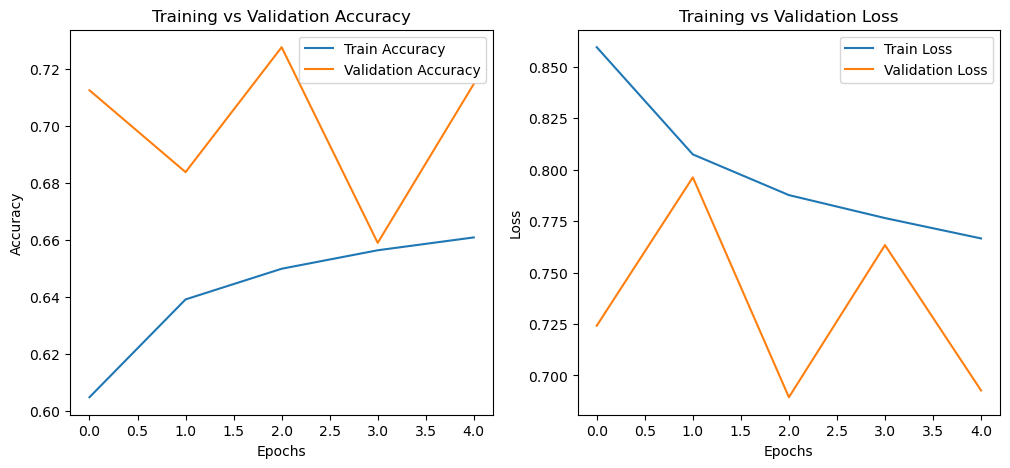

In [51]:
# Extract accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

In [187]:
# Time calculation for predictions
sn_time = time.time()
y_train_pred = model.predict(X_train)  # Predicted probabilities
y_test_pred = model.predict(X_test)    # Predicted probabilities
en_time = time.time()
testing_time = en_time - sn_time

5746/5746 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [233]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
import time

# Compute evaluation metrics for a multi-class classification model
def compute_metrics(y_train_pred, y_train, y_test_pred, y_test, training_time, testing_time, epochs):
    
    # Convert one-hot encoded labels to class indices
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Compute AUC (Multi-class ROC AUC)
    try:
        auc_train = roc_auc_score(y_train, y_train_pred, multi_class='ovr', average='macro')  # Using average='macro' for multi-class
    except ValueError:
        auc_train = 'N/A'

    try:
        auc_test = roc_auc_score(y_test, y_test_pred, multi_class='ovr', average='macro')  # Using average='macro' for multi-class
    except ValueError:
        auc_test = 'N/A'

    # Compute F1 Score per class
    f1_train = f1_score(y_train_labels, np.argmax(y_train_pred, axis=1), average=None)
    f1_test = f1_score(y_test_labels, np.argmax(y_test_pred, axis=1), average=None)

    # Compute Accuracy
    accuracy_train = accuracy_score(y_train_labels, np.argmax(y_train_pred, axis=1))
    accuracy_test = accuracy_score(y_test_labels, np.argmax(y_test_pred, axis=1))

    # Store results
    results_train = {
        'Type': 'Training',
        'Epoch': epochs,
        'Time Taken': training_time,
        'Accuracy': accuracy_train,
        'F1 Score (Negative)': f1_train[0] if len(f1_train) > 0 else 'N/A',
        'F1 Score (Neutral)': f1_train[1] if len(f1_train) > 1 else 'N/A',
        'F1 Score (Positive)': f1_train[2] if len(f1_train) > 2 else 'N/A',
        'AUC': auc_train
    }
    
    results_test = {
        'Type': 'Testing',
        'Epoch': epochs,
        'Time Taken': testing_time,  # Keeping this unchanged as per request
        'Accuracy': accuracy_test,
        'F1 Score (Negative)': f1_test[0] if len(f1_test) > 0 else 'N/A',
        'F1 Score (Neutral)': f1_test[1] if len(f1_test) > 1 else 'N/A',
        'F1 Score (Positive)': f1_test[2] if len(f1_test) > 2 else 'N/A',
        'AUC': auc_test
    }

    # Store results in DataFrame
    results_df = pd.DataFrame([results_train, results_test])

    return results_df

In [235]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Plots ROC curves and confusion matrices for a multi-class model.
def plot_results(y_train, y_train_pred, y_test, y_test_pred, class_labels):
    
    # Convert one-hot encoded labels back to class indices
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    y_train_pred_labels = np.argmax(y_train_pred, axis=1)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)

    # Binarize labels for ROC computation
    y_train_bin = label_binarize(y_train_labels, classes=np.arange(len(class_labels)))
    y_test_bin = label_binarize(y_test_labels, classes=np.arange(len(class_labels)))

    # Create subplots for ROC curves
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Add one more subplot for overall ROC

    # Plot ROC curve for Train set
    for i in range(len(class_labels)):
        fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_pred[:, i])
        roc_auc_train = auc(fpr_train, tpr_train)
        axes[0].plot(fpr_train, tpr_train, lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc_train:.2f})')

    # Plot ROC curve for Test set
    for i in range(len(class_labels)):
        fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_pred[:, i])
        roc_auc_test = auc(fpr_test, tpr_test)
        axes[1].plot(fpr_test, tpr_test, lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc_test:.2f})')


    # Plot ROC Curve for training vs testing comparison (overall)
    axes[2].plot(fpr_train, tpr_train, lw=2, label=f'Train AUC = {roc_auc_train:.2f}', linestyle='--')
    axes[2].plot(fpr_test, tpr_test, lw=2, label=f'Test AUC = {roc_auc_test:.2f}')

    # Add diagonal line for reference in all subplots
    for ax in axes:
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')

    axes[0].set_title('Training Data ROC Curve')
    axes[1].set_title('Testing Data ROC Curve')
    axes[2].set_title('Training vs Testing ROC Curve')

    # Ensure legend is displayed for all subplots
    for ax in axes:
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    # Compute confusion matrices
    cm_train = confusion_matrix(y_train_labels, y_train_pred_labels)
    cm_test = confusion_matrix(y_test_labels, y_test_pred_labels)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Confusion Matrix - Training
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
    axes[0].set_title('Confusion Matrix - Training')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    # Plot Confusion Matrix - Testing
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
    axes[1].set_title('Confusion Matrix - Testing')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

In [239]:
# Storing Results
results_df = compute_metrics(y_train_pred, y_train, y_test_pred, y_test, training_time, testing_time, epochs=5)
results_df

,Type,Epoch,Time Taken,Accuracy,F1 Score (Negative),F1 Score (Neutral),F1 Score (Positive),AUC
0,Training,5,918.054158,0.672029,0.671863,0.621190,0.712779,0.843310
1,Testing,5,20.519886,0.714813,0.548339,0.541943,0.819890,0.852028


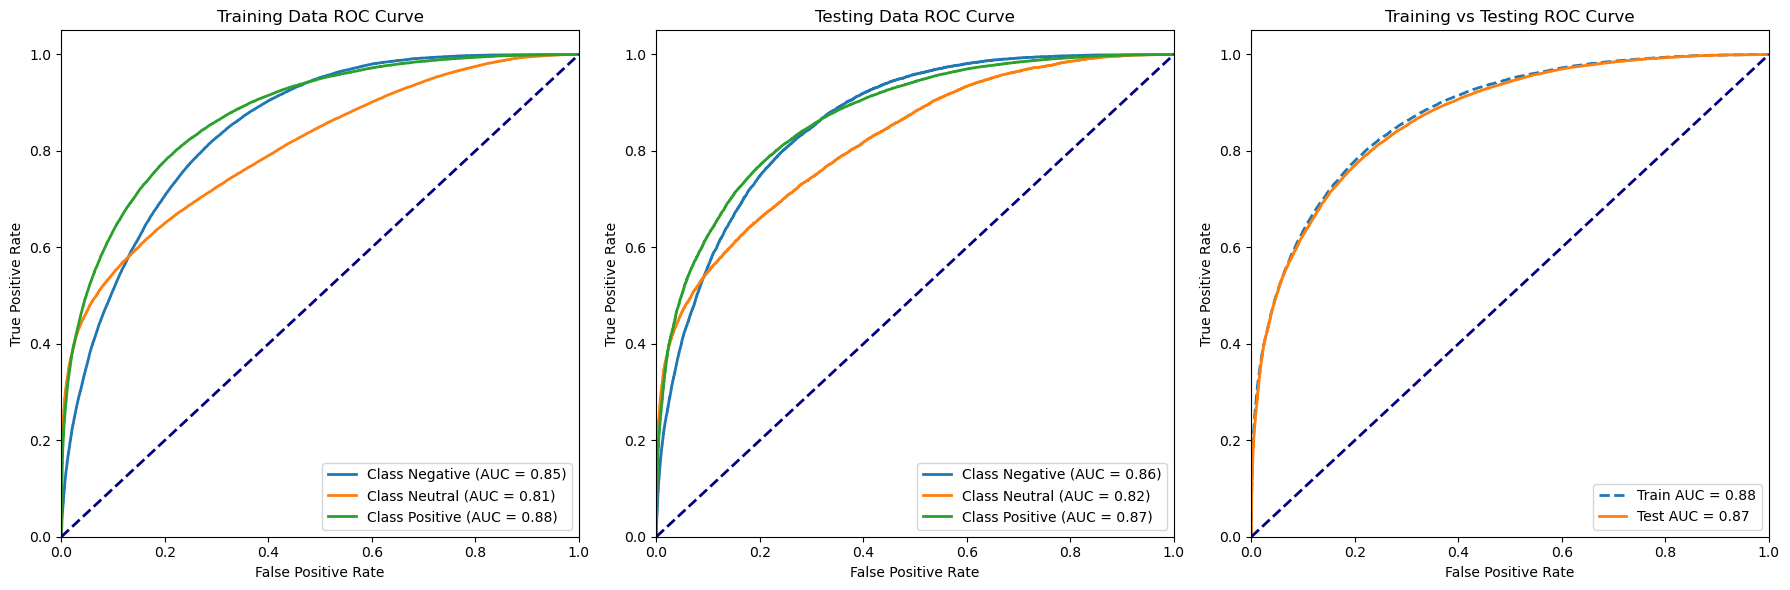

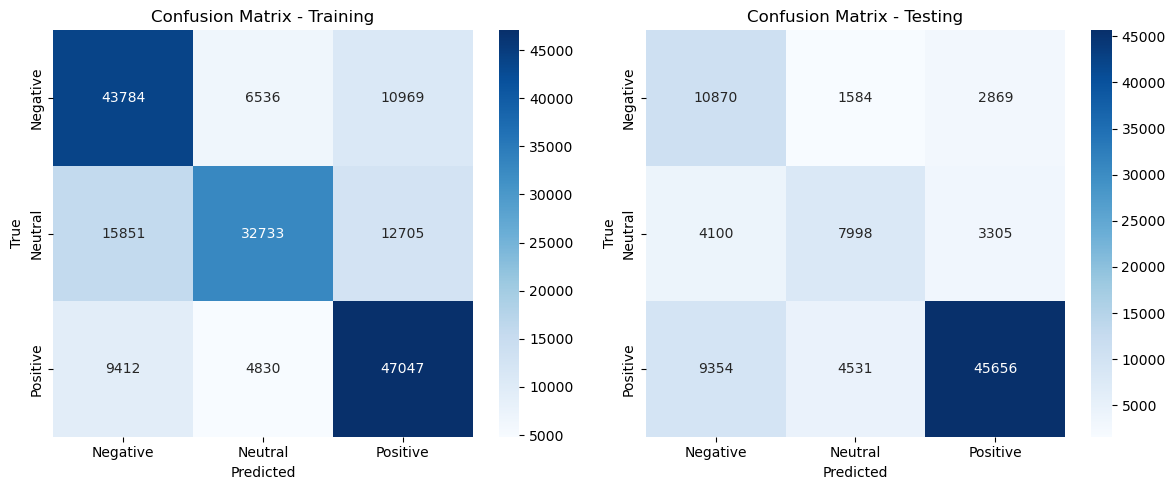

In [241]:
# Call the updated plot_results function
plot_results(y_train, y_train_pred, y_test, y_test_pred, class_labels)

In [247]:
# Save the entire model
model.save('non_causal_tf.keras')
print("Model Saved")

Model Saved


In [257]:
# Assuming train_df and test_df are already defined
merged_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# Save as CSV
merged_df.to_csv("tokenized_clean_sentiment_data.csv", index=False)

print("Merged DataFrame saved as 'tokenized_clean_sentiment_data.csv'")

Merged DataFrame saved as 'tokenized_clean_sentiment_data.csv'


In [335]:
import ast
import lime
import lime.lime_text
import numpy as np
import tensorflow as tf

# Function to make predictions for LIME with TensorFlow model
def lime_predict(texts):
    # Convert text to vectorized embeddings using your custom embedding function
    vectors = [get_embedding(word_tokenize(text.lower()), w2v_model) for text in texts]
    
    # Reshape each input to be (1, 100), meaning 1 token with 100 features
    reshaped_vectors = [vec.reshape(1, -1) for vec in vectors]
    
    # Stack the reshaped vectors to form a batch (shape: [batch_size, 1, embedding_size])
    tensors = np.array(reshaped_vectors)

    # Convert list of vectors into a TensorFlow tensor
    tensors = tf.convert_to_tensor(tensors, dtype=tf.float32)
    
    # Move the tensors to the correct device (if needed)
    with tf.device(device):  # Specify the device (CPU or GPU)
        outputs = model(tensors, training=False)  # Set training=False to ensure inference mode
    
    return tf.nn.softmax(outputs).numpy()

# Initialize LIME explainer with class labels
explainer = lime.lime_text.LimeTextExplainer(class_names=label_encoder.classes_)

# Select a random tweet for interpretation (make sure the input is a string)
sample_index = np.random.randint(0, len(df))
sample_tweet = df.iloc[sample_index]["Tweet_Cleaned"]

# Get explanation for the selected tweet
lime_exp = explainer.explain_instance(sample_tweet, lime_predict, num_features=10)

# Show LIME explanation in notebook
lime_exp.show_in_notebook()

In [ ]:
# Initialize a list to store explanations
explanations = []

# Collect explanations for exactly 100 random tweets
num_samples = 100  # Number of samples you want to collect explanations for

for i in range(num_samples):
    sample_index = np.random.randint(0, len(df))  # Random index between 0 and number of rows in df
    sample_tweet = df.iloc[sample_index]["Tweet_Cleaned"]  # Use the cleaned tweet column

    # Get the LIME explanation for the current tweet
    lime_exp = explainer.explain_instance(sample_tweet, lime_predict, num_features=10)
    explanations.append(lime_exp)

# Analyze the global explanations
for i, exp in enumerate(explanations):
    print(f"Explanation for Sample {i + 1}:")
    print(exp.as_list())  # This will show the feature importance list for the sample
    print("\n")

In [ ]:
# Extract the features and visualize them globally

feature_importance = {}
for exp in explanations:
    for feature, weight in exp.as_list():
        if feature in feature_importance:
            feature_importance[feature] += weight
        else:
            feature_importance[feature] = weight

# Sort features by total importance
sorted_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Plot top 10 most important features
top_features = sorted_features[:10]
features, importance = zip(*top_features)

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()  # Reverse the y-axis to have the most important at the top
plt.show()